# Introduction-to-Time-Series-Forecasting">Introduction to Time Series Forecasting
Time series is different from more traditional classification and regression predictive modeling problems. The temporal structure adds an order to the observations. This imposed order means that important assumptions about the consistency of those observations needs to be handled specifically.
The goal of Time Series Forecasting is to make accurate predictions about the future. In this Jupyter Notebook, we will focus on how to make predictions on univariate time series problems using the standard tools in the Python ecosystem. <a href="http://pandas.pydata.org/">Pandas</a> library in Python provides excellent, built-in support for time series data, while <a href="http://statsmodels.sourceforge.net/">Statsmodels</a> is a Python module that allows users to explore data, estimate statistical models, and perform statistical tests.</p>
Download the Effective Federal Funds Rate dataset from <a href="https://fred.stlouisfed.org/series/FEDFUNDS">FRED Economic Data website</a>. The federal funds rate is the interest rate at which depository institutions trade federal funds with each other overnight. We will focus on forecasting the interest rates up to the 2008 financial crisis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA


In [ ]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20


<h2 id="Data-Preparation">Data Preparation<a class="anchor-link" href="#Data-Preparation">¶</a></h2>



<h3 id="Load-and-Explore-Time-Series-Data">Load and Explore Time Series Data<a class="anchor-link" href="#Load-and-Explore-Time-Series-Data">¶</a></h3>


In [ ]:
# load dataset
dataframe = pd.read_csv('FEDFUNDS.csv',
                        index_col='DATE',
                        dtype={'FEDFUNDS': np.float32},
                        parse_dates=True, 
                        date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m-%d'),
                       )

In [ ]:
# display first few lines of a time series
dataframe.head()

In [ ]:
# the index is in datetime format, which is fine
dataframe.index[:5]

In [ ]:
# however, this doesn't look good yet
dataframe.head().values

In [ ]:
# unstacking the data might help...
dataframe.unstack().head()

In [ ]:
# and it does
dataframe.unstack().head().values


<h4 id="Create-Time-Series">Create Time Series<a class="anchor-link" href="#Create-Time-Series">¶</a></h4><p>Pandas represents time series datasets as a Series. A Series is a one-dimensional array with a time label for each row.</p>


In [ ]:
# create a time series
s = pd.Series(dataframe.unstack().values, index=dataframe.index)

In [ ]:
# basic plot
s.plot();

In [ ]:
# query a dataset using a date-time index
s[:'2007'].tail(10)

In [ ]:
s.head()

In [ ]:
# keep only data before 2008 
s = s[:'2007']


<h4 id="Explore-Time-Series-Data">Explore Time Series Data<a class="anchor-link" href="#Explore-Time-Series-Data">¶</a></h4>


In [ ]:
# display first few lines of a time series
s.head()

In [ ]:
s.index[:5]

In [ ]:
# display last few lines of a time series
s.tail()

In [ ]:
# summarize the dimensions of a time series
s.size

In [ ]:
# calculate descriptive statistics
s.describe()

In [ ]:
# query a dataset using a date-time index
s['1999-06':'2000-06']


<h3 id="Basic-Feature-Engineering">Basic Feature Engineering<a class="anchor-link" href="#Basic-Feature-Engineering">¶</a></h3>



<p>Time Series data must be re-framed as a supervised learning dataset before we can start using
machine learning algorithms. There is no concept of input and output features in time series.
Instead, we must choose the variable to be predicted and use feature engineering to construct
all of the inputs that will be used to make predictions for future time steps.</p>
<p>A time series dataset must be transformed to be modeled as a supervised learning problem. We need to transform something that looks like:</p>
<pre><code>time 1, value 1
time 2, value 2
time 3, value 3
</code></pre>
<p>into something that looks like:</p>
<pre><code>input 1, output 1
input 2, output 2
input 3, output 3</code></pre>



<h4 id="Date-Time-Features">Date Time Features<a class="anchor-link" href="#Date-Time-Features">¶</a></h4><p>The simplest features that we can use are features from the date/time of each observation.</p>


In [ ]:
df = pd.DataFrame()
df['year'] = [s.index[i].year for i in range(len(s))]
df['month'] = [s.index[i].month for i in range(len(s))]
df['value'] = s.values.tolist()

In [ ]:
df.head()

#### Lag Features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the current time (t). The supervised learning problem with shifted values looks as follows:</p>
<pre><code>Value(t), Value(t+1)
Value(t), Value(t+1)
Value(t), Value(t+1)</code></pre>


In [ ]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [ ]:
df.head()

In [ ]:
df.tail()

#### Window Features
The addition of lag features is called the sliding window method, in this case with a window width of 1. It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width. We can expand the window width and include more lagged features.

In [ ]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(3), values.shift(2), values.shift(1), values], axis=1)
df.columns = ['t-2', 't-1', 't', 't+1']

In [ ]:
df.head()

In [ ]:
df.tail()

#### Rolling Window Statistics
A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous values, also called the rolling mean.</p>


In [ ]:
values = pd.DataFrame(s.values)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

df = pd.concat([means, values], axis=1)
df.columns = ['mean(t-1,t)', 't+1']

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
values = pd.DataFrame(s.values)
width = 3
shifted = values.shift(width - 1)
window = shifted.rolling(window=width)

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']

In [ ]:
df.head()

In [ ]:
df.tail()

#### Expanding Window Statistics
Another type of window that may be useful includes all previous data in the series. This is called an expanding window and can help with keeping track of the bounds of observable data.

In [ ]:
values = pd.DataFrame(s.values)
window = values.expanding()

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']

In [ ]:
df.head()

In [ ]:
df.tail()

### Data Visualization
Time series lends itself naturally to visualization. Line plots of observations over time are popular, but there is a suite of other plots that you can use to learn more about your problem. The more you learn about your data, the more likely you are to develop a better forecasting model.

#### Line-Plot
Perhaps the most popular visualization for time series is the line plot. In this plot, time is shown on the x-axis with observation values along the y-axis.</p>


In [ ]:
s.plot();

In [ ]:
s.plot(style='k.');

#### Histogram and Density Plots
Another important visualization is of the distribution of observations themselves. This means a plot of the values without the temporal ordering. Some linear time series forecasting methods assume a well-behaved distribution of observations (i.e. a bell curve or normal distribution). This can be explicitly checked using tools like statistical hypothesis tests. But plots can provide a useful first check of the distribution of observations both on raw observations and after any type of data transform has been performed.

In [ ]:
s.hist();

In [ ]:
s.plot(kind='kde');

#### Box and Whisker Plots
Histograms and density plots provide insight into the distribution of all observations, but we
may be interested in the distribution of values by time interval. Another type of plot that is
useful to summarize the distribution of observations is the box and whisker plot. This plot
draws a box around the 25th and 75th percentiles of the data that captures the middle 50% of
observations. A line is drawn at the 50th percentile (the median) and whiskers are drawn above
and below the box to summarize the general extents of the observations. Dots are drawn for
outliers outside the whiskers or extents of the data.

In [ ]:
years, index = [], []
for name, gr in s.groupby(Grouper(freq='Y')):
    years.append(gr.values)
    index.append(name.year)
df = pd.DataFrame(years, index=index, columns=range(1,13))

In [ ]:
df.tail(10)

In [ ]:
df.head(10).T.boxplot();

Comparing box and whisker plots by consistent intervals is a useful tool. Within an interval,it can help to spot outliers (dots above or below the whiskers). Across intervals, in this case years, we can look for multiple year trends, seasonality, and other structural information that could be modeled.

In [ ]:
df.tail(10).T.boxplot()


<h4 id="Heat-Maps">Heat Maps<a class="anchor-link" href="#Heat-Maps">¶</a></h4>


In [ ]:
plt.matshow(df.T, interpolation=None, aspect='auto');

In [ ]:
sns.heatmap(df.T);

#### Lag Scatter Plots
Time series modeling assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag=1, the observation at two time steps ago lag=2, and so on. A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot. Pandas has a built-in function for exactly this called the lag plot. It plots the observation at time t on the x-axis and the lag=1 observation (t-1) on the y-axis.
- If the points cluster along a diagonal line from the bottom-left to the top-right of the plot,it suggests a positive correlation relationship.
- If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
- Either relationship is good as they can be modeled.

More points tighter in to the diagonal line suggests a stronger relationship and more spread
from the line suggests a weaker relationship. A ball in the middle or a spread across the plot
suggests a weak or no relationship.


In [ ]:
# create a scatter plot
lag_plot(s);

In [ ]:
# create multiple scatter plots
values = pd.DataFrame(s.values)
lags = 8
columns = [values]

for i in range(1,(lags + 1)):
    columns.append(values.shift(i))

df = pd.concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
df.columns = columns

plt.figure(1, figsize=(15,9))
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=df['t+1'].values, y=df['t-'+str(i)].values)


#### Autocorrelation Plots
We can quantify the strength and type of relationship between observations and their lags. In
statistics, this is called correlation, and when calculated against lag values in time series, it is
called autocorrelation (self-correlation). A correlation value calculated between two groups of
numbers, such as observations and their lag=1 values, results in a number between -1 and 1. The sign of this number indicates a negative or positive correlation respectively. A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation.
Correlation values, called correlation coeficients, can be calculated for each observation and
different lag values. Once calculated, a plot can be created to help better understand how this
relationship changes over the lag. This type of plot is called an <strong>autocorrelation plot.


In [ ]:
#  create an autocorrelation plot
autocorrelation_plot(s);

The Statsmodels library also provides a version of the autocorrelation plot as a line plot. Plots lags on the horizontal and the correlations on vertical axis.

In [ ]:
# autocorrelation plot of time series as a line plot
plot_acf(s, lags=50)
plt.show()

In [ ]:
# create an autocorrelation plot, using only the last 100 entries
autocorrelation_plot(s[-100:]);

In [ ]:
# autocorrelation plot of time series as a line plot
plot_acf(s[-100:], lags=50)
plt.show()

### Moving Average Smoothing
Moving average smoothing is a naive and effective technique in time series forecasting. It can be used for data preparation, feature engineering, and even directly for making predictions. Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.

In [ ]:
# tail-rolling average transform
rolling = s.rolling(window=3)
rolling_mean = rolling.mean()

In [ ]:
rolling_mean.head(10)

In [ ]:
# plot original and transformed dataset
s[-100:].plot()
rolling_mean[-100:].plot(color='red');

#### Moving Average as Prediction
The moving average value can also be used directly to make predictions. It is a naive model
and assumes that the trend and seasonality components of the time series have already been
removed or adjusted for. The moving average model for predictions can easily be used in a
walk-forward manner. As new observations are made available (e.g. daily), the model can be
updated and a prediction made for the next day.

In [ ]:
# prepare problem
X = s.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [ ]:
print('RMSE: %.3f' % rmse)

In [ ]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show()

### Time Series Components
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components

- **Systematic**: Components of the time series that have consistency or recurrence and can
be described and modeled.
- **Non-Systematic**: Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level,
trend, seasonality, and one non-systematic component called noise. These components are
defined as follows:

- **Level**: The average value in the series.
- **Trend**: The increasing or decreasing value in the series.
- **Seasonality**: The repeating short-term cycle in the series.
- **Noise**: The random variation in the series.

Our time series dataset may contain a trend. A trend is a continued increase or decrease in
the series over time. There can be benefit in identifying, modeling, and even removing trend
information from your time series dataset.
Time series datasets can contain a seasonal component. This is a cycle that repeats over time,
such as monthly or yearly. This repeating cycle may obscure the signal that we wish to model
when forecasting, and in turn may provide a strong signal to our predictive models. There are many types of seasonality: time of day, daily, weekly, monthly, yearly etc. Identifying whether there is a seasonality component in your time series problem is
subjective. The simplest approach to determining if there is an aspect of seasonality is to plot and review your data, perhaps at different scales and with the addition of trend lines.

A time series where the seasonal component has been removed is called **seasonal stationary**. If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be **trend stationary**.


### Stationarity in Time Series Data

The observations in a stationary time series are not dependent on time. Time series are stationary
if they do not have trend or seasonal effects. Summary statistics calculated on the time series
are consistent over time, like the mean or the variance of the observations. When a time series
is stationary, it can be easier to model. Statistical modeling methods assume or require the
time series to be stationary to be effective.</p>


#### Check for Stationarity
There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

- **Look at Plots**: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
- **Summary Statistics**: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
- **Statistical Tests**: You can use statistical tests to check if the expectations of stationarity are met or have been violated.

In [ ]:
s.plot();

#### Augmented-Dickey-Fuller-test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [ ]:
# calculate stationarity test of time series data
X = s.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

We can see that our statistic value of -3.185 is less than the value of -2.866 at 5%. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

## Evaluate-Models

The goal of time series forecasting is to make accurate predictions about the future. The fast and powerful methods that we rely on in machine learning, such as using *train-test splits* and *k-fold cross-validation*, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem.
In time series forecasting, this evaluation of models on historical data is called **backtesting**. We will look at three different methods that you can use to backtest your machine learning models on time series problems:

- **Train-Test split** that respects temporal order of observations.
- **Multiple Train-Test splits** that respect temporal order of observations.
- **Walk-Forward Validation** where a model may be updated each time step new data is received.

### Train-Test Split

In [ ]:
# calculate a train-test split of a time series dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

In [ ]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

In [ ]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r');

### Multiple Train-Test Splits
We can repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data. We could do this manually by repeating the train-split tests with different split points.

The scikit-learn library provides a time series "cross-validator" in the `TimeSeriesSplit` module. It provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

In [ ]:
# calculate repeated train-test splits of time series data
X = s.values
splits = TimeSeriesSplit(n_splits=3)
index = 1
plt.figure(1, figsize=(15,9))

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n-----' % (len(test)))

    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test], color='r')
    index += 1
plt.show() 

Using multiple train-test splits will result in more models being trained, and in turn, a
more accurate estimate of the performance of the models on unseen data. A limitation of the
train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set. This may not be realistic as models can be retrained as new daily or monthly observations are made available.

### Walk Forward Validation

In practice, we very likely will retrain our model as new data becomes available. This would
give the model the best opportunity to make good forecasts at each time step.
There are few decisions to make:

- **Minimum Number of Observations**. First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).
- **Sliding or Expanding Window**. Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.

In [ ]:
# walk forward validation: the train set expanding each time step
# and the test set fixed at one time step ahead
X = s[-100:].values
n_train = 80
n_records = len(X)

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

### Persistence Model for Forecasting
Establishing a baseline is essential on any time series forecasting problem. A baseline in performance gives you an idea of how well all other models will actually perform on your problem. Here we will develop a persistence forecast that we can use later as a baseline level of performance on this time series dataset.
The following steps are required:

- Transform the univariate dataset into a supervised learning problem.
- Establish the train and test datasets for the test harness.
- Define the persistence model.
- Make a forecast and establish a baseline performance.
- Review the complete example and plot the output.

In [ ]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [ ]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [ ]:
# persistence model
def model_persistence(x):
    return x

In [ ]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [ ]:
print('Test RMSE: %.3f' % rmse)

In [ ]:
# plot predictions and expected results on the test data
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions]);

### Visualize Residual Forecast Errors

Forecast errors on a time series forecasting problem are called <em>residual errors</em> or <em>residuals</em>. A residual error is calculated as the expected outcome minus the forecast. Careful exploration of residual errors on your time series prediction problem can tell you a lot about your forecast model and even suggest improvements.</p>


In [ ]:
# calculate residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)


<p>The first plot is to look at the residual forecast errors over time as a line plot. We would expect the plot to be random around the value of 0 and not show any trend or cyclic structure.</p>


In [ ]:
# plot residuals
residuals.plot();


<p>We can calculate summary statistics on the residual errors. Primarily, we are interested in
the mean value of the residual errors. A value close to zero suggests no bias in the forecasts,
whereas positive and negative values suggest a positive or negative bias in the forecasts made.
It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior
to their use or evaluation.</p>


In [ ]:
residuals.describe()

Plots can be used to better understand the distribution of errors beyond summary statistics.
We would expect the forecast errors to be normally distributed around a zero mean.

In [ ]:
# histograms plot
residuals.hist();

In [ ]:
# density plot
residuals.plot(kind='kde');

#### Residual Q-Q Plot
A Q-Q plot, or quantile plot, compares two distributions and can be used to see how similar or different they happen to be. The Q-Q plot can be used to quickly check the normality of the distribution of residual errors. The values are ordered and compared to an idealized Gaussian distribution. The comparison is shown as a scatter plot (theoretical on the x-axis and observed on the y-axis) where a match between the two distributions is shown as a diagonal line from the bottom left to the top-right of the plot.</p>


In [ ]:
qqplot(residuals, line='r')
plt.show()

#### Residual Autocorrelation Plot

We would not expect there to be any correlation between the residuals. This would be shown by autocorrelation scores being
below the threshold of significance (dashed and dotted horizontal lines on the plot). A significant autocorrelation in the residual plot suggests that the model could be doing a better job of incorporating the relationship between observations and lagged observations, called <em>autoregression</em>.


In [ ]:
autocorrelation_plot(residuals);

In [ ]:
# autocorrelation plot of residuals as a line plot
plot_acf(residuals, lags=20)
plt.show()

### Reframe Time Series Forecasting Problems
There are many ways to reframe the forecast problem that can both simplify the prediction problem and potentially
expose more or different information to be modeled. A reframing can ultimately result in better and/or more robust forecasts.</p>


### Classification Framings
Classification involves predicting categorical or label outputs (such as <em>high</em>, <em>medium</em>, and <em>low</em>). For example, we can forecast whether a change in minimum value will be small or large, or whether the new value will be lower or higher than the current value.</p>


In [ ]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [ ]:
def make_discrete(row):
   if row['t+1'] < 0:
      return 'low'
   elif row['t+1'] > 3:
      return 'high'
   else:
      return 'medium'

In [ ]:
# apply the above function to reassign t+1 values
df['t+1'] = df.apply(lambda row: make_discrete(row), axis=1)

In [ ]:
# Randomly sample 10 elements from the dataframe
df.sample(n=10)

#### Time Horizon Framings

<ul>
<li>Forecast the minimum value for the next 3 months.</li>
<li>Forecast the maximum value relative to the average from the past 12 months.</li>
<li>Forecast the month in the next year that will have the lowest value.</li>
<li>...</li>
</ul>

In [ ]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values, values.shift(-1), values.shift(-2)], axis=1)
df.columns = ['t', 't+1', 't+2', 't+3']

In [ ]:
df.head()

We can now define the problem as: given the minimum interest rate from the day before, forecast the minimum value for the next 3 days.

# Ejercicio

Para la serie temporal `AirPassengers.csv`:

1. Realice una exploración gráfica de la serie temporal (Line plot, density plot, boxplots, autocorrelation plots, etc.)
2. Construya una ventana de características (Window features) de: 
     a) 4 valores retrasados
     b) del mínimo, media, máximo, rango y desviación estándar para una ventana de tamaño 3 (retrasada)
3. Realice un moving average smoothing con una ventana de tamaño 5. Visualice el resultado.
4. ¿La serie es estacionaria?
5. Realice una división train-test 
6. Construya un modelo persistente como modelo de referencia sobre el train set. Evalue sobre el test set, revise los residuos. Concluya
7. Construya dos modelos de predicción usando regresión lineal usando las tablas del punto 2 sobre el train set, evalúe el resultado en el Test set y observe los residuos. Concluya
8. Construya un modelo de predicción usando moving average sobre el train set, evalue sobre el test set, revise los residuos. Concluya.    
  

# Desarollado por Samuel Pérez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

In [3]:
df = pd.read_csv("AirPassengers.csv")

#Parse strings to datetime type
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True) #convert from string to datetime
df_ind = df.set_index(['Month'])
df_ind.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Punto 1

In [4]:
s = pd.Series(df_ind.unstack().values, index=df_ind.index)

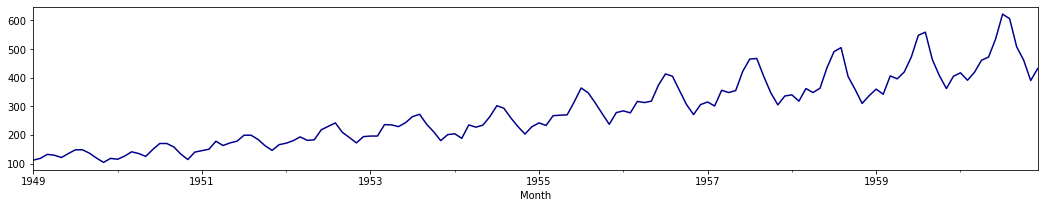

In [5]:
s.plot(color='darkblue');

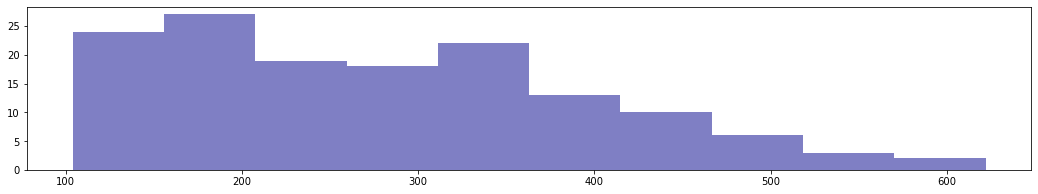

In [6]:
s.hist(alpha = 0.5,color='darkblue',grid=False);

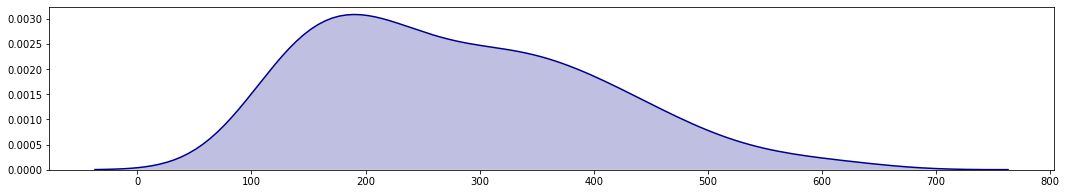

In [7]:
sns.kdeplot(s, shade=True,color='darkblue');

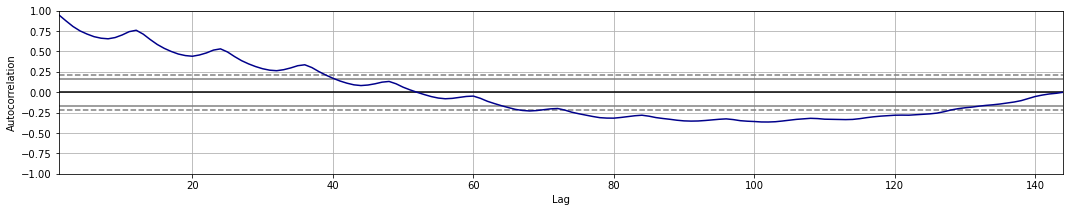

In [8]:
autocorrelation_plot(s, color='darkblue')

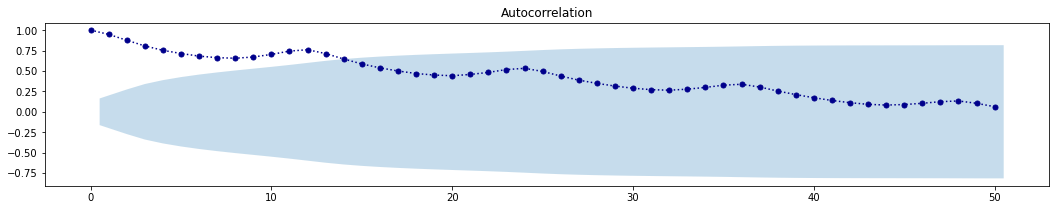

In [9]:
plot_acf(s, lags=50, color='darkblue', linestyle=':',use_vlines=False)
plt.show()

In [10]:
years, index = [], []
for name, gr in s.groupby(Grouper(freq='Y')):
    years.append(gr.values)
    index.append(name.year)
df_box = pd.DataFrame(years, index=index, columns=range(1,13))
df_box.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1949,112,118,132,129,121,135,148,148,136,119,104,118
1950,115,126,141,135,125,149,170,170,158,133,114,140
1951,145,150,178,163,172,178,199,199,184,162,146,166
1952,171,180,193,181,183,218,230,242,209,191,172,194
1953,196,196,236,235,229,243,264,272,237,211,180,201


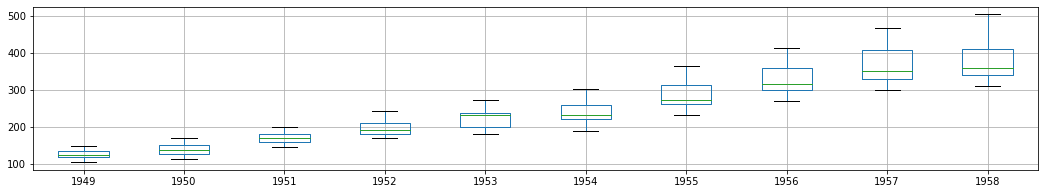

In [11]:
df_box.head(10).T.boxplot();

## Punto 2

In [12]:
values = pd.DataFrame(s.values)
df_win1 = pd.concat([values.shift(4),values.shift(3), values.shift(2), values.shift(1), values], axis=1)
df_win1.columns = ['t-3','t-2', 't-1', 't', 't+1']
df_win1.head(10)

,t-3,t-2,t-1,t,t+1
0,nan,nan,nan,nan,112
1,nan,nan,nan,112.00,118
2,nan,nan,112.00,118.00,132
3,nan,112.00,118.00,132.00,129
4,112.00,118.00,132.00,129.00,121
5,118.00,132.00,129.00,121.00,135
6,132.00,129.00,121.00,135.00,148
7,129.00,121.00,135.00,148.00,148
8,121.00,135.00,148.00,148.00,136
9,135.00,148.00,148.00,136.00,119


In [13]:
values = pd.DataFrame(s.values)
width = 3
shifted = values.shift(width - 1)
window = shifted.rolling(window=width)
df_win2 = pd.concat([window.min(), window.mean(), window.max(),window.max() - window.min(), window.std(),values], axis=1)
df_win2.columns = ['min', 'mean', 'max', 'range', 'std', 't+1']
df_win2.head(10)

,min,mean,max,range,std,t+1
0,nan,nan,nan,nan,nan,112
1,nan,nan,nan,nan,nan,118
2,nan,nan,nan,nan,nan,132
3,nan,nan,nan,nan,nan,129
4,112.00,120.67,132.00,20.00,10.26,121
5,118.00,126.33,132.00,14.00,7.37,135
6,121.00,127.33,132.00,11.00,5.69,148
7,121.00,128.33,135.00,14.00,7.02,148
8,121.00,134.67,148.00,27.00,13.50,136
9,135.00,143.67,148.00,13.00,7.51,119


## Punto 3

In [14]:
# tail-rolling average transform
rolling = s.rolling(window=5)
rolling_mean = rolling.mean()

In [15]:
rolling.mean().head(10)

Month
1949-01-01      nan
1949-02-01      nan
1949-03-01      nan
1949-04-01      nan
1949-05-01   122.40
1949-06-01   127.00
1949-07-01   133.00
1949-08-01   136.20
1949-09-01   137.60
1949-10-01   137.20
dtype: float64

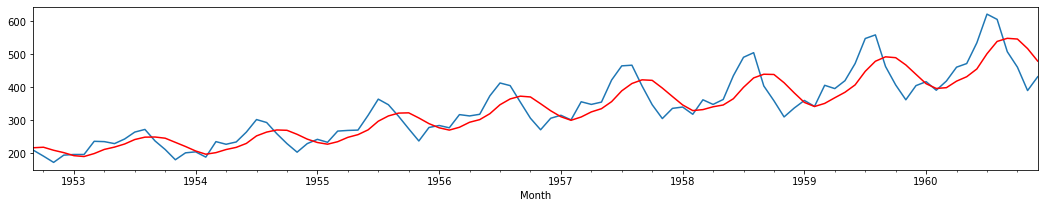

In [16]:
# plot original and transformed dataset
s[-100:].plot()
rolling_mean[-100:].plot(color='red');

## Punto 4

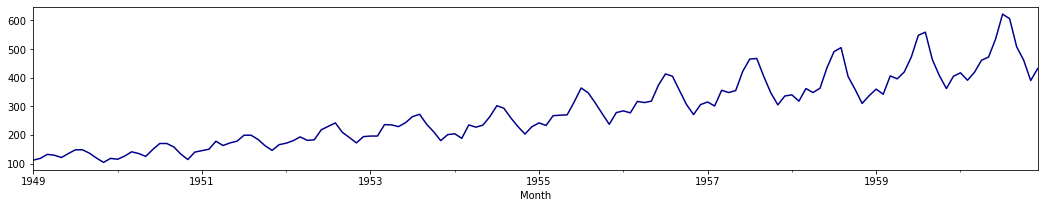

In [17]:
s.plot(color='darkblue');

Con un análisis meramente gráfico, podríamos decir que la serie NO es estacional, pues notamos claros unos componentes de seasonality y tendencia.

In [18]:
# calculate stationarity test of time series data
X = s.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Además, observe que a través del Augmented-Dickey-Fuller-test obtenemos un estadístico que es positivo y mayor a los valores críticos porcentuales presentados, por lo tanto no podemos rechazar la hipótesis nula, sugiriendo que la serie no es estacional. Esto se confirma al observar nuestro p value, que en este caso corresponde a un p>0.05, lo cual nos indica que fallamos al rechazar la hipótesis nula, por tanto los datos tienen una "raiz unidad" (unit root) y es no estacional.

## Punto 5

In [19]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 144
Training Observations: 94
Testing Observations: 49


## Punto 6

In [20]:
def model_persistence(x):
    return x

In [21]:
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 47.811


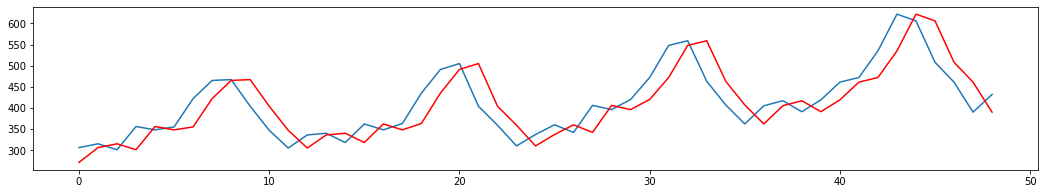

In [22]:
plt.plot(test_y[:100])
plt.plot(predictions[0:100], color='red')
plt.show()

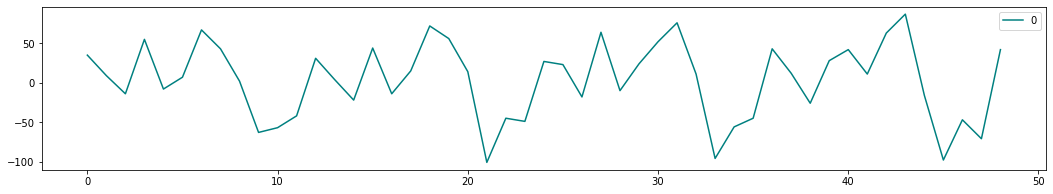

In [23]:
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
residuals.plot(color='teal');

In [24]:
residuals.describe()

,0
count,49.00
mean,3.29
std,48.19
min,-101.00
25%,-26.00
50%,11.00
75%,42.00
max,87.00


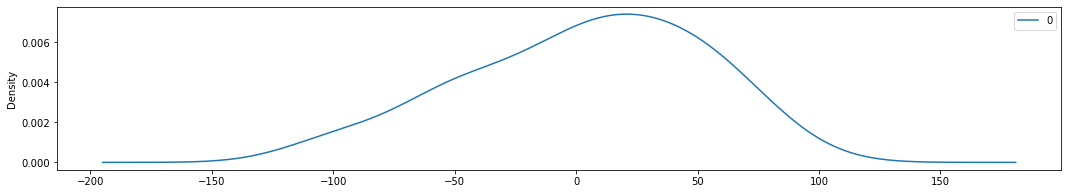

In [25]:
residuals.plot(kind='kde');

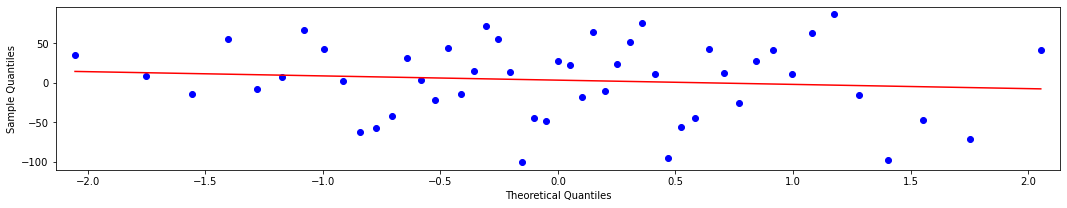

In [26]:
qqplot(residuals, line='r')
plt.show()

Nuestros resultados residuales, al tener las estadísticas descriptivas y haciendo enfoque en error medio, vemos de que el valor no es muy cercano a cero (3.29), y sugiere que hay un sesgo fuerte en nuestros pronósticos. Es decir, debemos establecer correcciones a nuestro modelo o probar otros.

Por otro lado, podemos ver que nuestra gráfica de densidad del error tiene una similitud a una distribución gaussiana (normal). Sin embargo, al tener nuestro qqplot vemos que las distribuciones en realidad difieren bastante. Observe que nuestra RMSE es bastante grande, por lo tanto podemos decir que nuestro modelo no se está ajustando de manera óptima a los datos.

## Punto 7 (ventanas de características y regresión lineal)

### Primer modelo con 4 valores retrasados

In [28]:
df_win1 = df_win1.fillna(method='bfill')
df_win1_model = df_win1[["t-3", "t-2","t-1", "t"]]

model = sm.OLS(train_y, df_win1_model[1:train_size]).fit()

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              2413.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):                    1.30e-90
Time:                        03:10:15   Log-Likelihood:                         -422.44
No. Observations:                  94   AIC:                                      852.9
Df Residuals:                      90   BIC:                                      863.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t-3            0.0772      0.113      0.681      0.498      -0.148       0.302
t-2            0.1240      0.177      0.701      0.485      -0.228       0.476
t-1           -0.5262      0.175     -3.005      0.003      -0.874      -0.178
t              1.3271      0.106     12.482      0.000       1.116       1.538
==============================================================================
Omnibus:                        4.410   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                4.338
Skew:                           0.483   Prob(JB):                        0.114
Kurtosis:                       2.580   Cond. No.                         48.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
predictions = model.predict(df_win1_model[train_size:].values) 

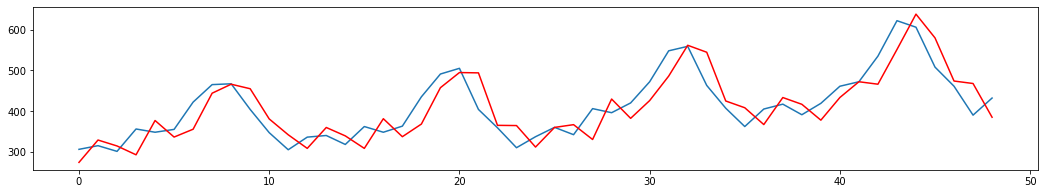

In [31]:
plt.plot(test_y[:100])
plt.plot(predictions[0:100], color='red')
plt.show()

In [32]:
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 43.672


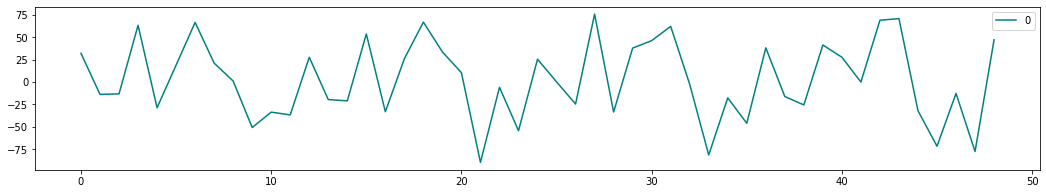

In [33]:
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
residuals.plot(color='teal');

In [34]:
residuals.describe()

,0
count,49.00
mean,2.42
std,44.06
min,-89.84
25%,-28.78
50%,-0.04
75%,37.86
max,75.81


A pesar de que el modelo tenga un estadístico R squared muy bueno, tenemos un sesgo bastante alto que se ve en la media de los residuales. Esto sugiere un mejoramiento o cambio de modelo. También nótese la métrica RMSE bastante alta.

### Segundo modelo con el mínimo, media, máximo, rango y desviación estándar para una ventana de tamaño 3 (retrasada)

In [35]:
df_win2 = df_win2.fillna(method='bfill')
df_win2_model = df_win2[['min', 'mean', 'max', 'range', 'std']]

model = sm.OLS(train_y, df_win2_model[1:train_size]).fit()

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              805.9
Date:                Wed, 02 Dec 2020   Prob (F-statistic):                    1.51e-69
Time:                        03:10:50   Log-Likelihood:                         -473.12
No. Observations:                  94   AIC:                                      954.2
Df Residuals:                      90   BIC:                                      964.4
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
min            4.0393      1.125      3.590      0.001       1.804       6.274
mean          -3.4879      1.402     -2.488      0.015      -6.273      -0.703
max            0.5411      1.077      0.502      0.617      -1.599       2.682
range         -3.4982      1.693     -2.066      0.042      -6.862      -0.135
std            9.2597      5.064      1.829      0.071      -0.801      19.320
==============================================================================
Omnibus:                       10.475   Durbin-Watson:                   0.944
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.570
Skew:                          -0.729   Prob(JB):                      0.00507
Kurtosis:                       3.758   Cond. No.                     6.44e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.28e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [41]:
predictions = model.predict(df_win2_model[train_size:].values) 

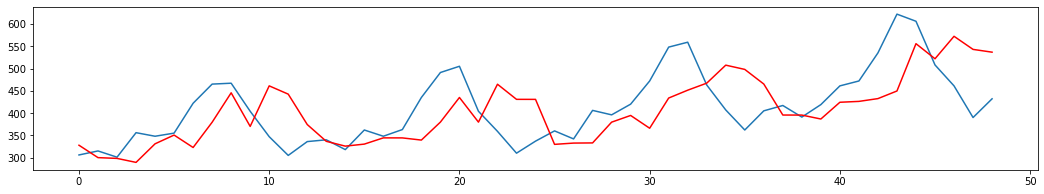

In [42]:
plt.plot(test_y[:100])
plt.plot(predictions[0:100], color='red')
plt.show()

In [43]:
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 77.014


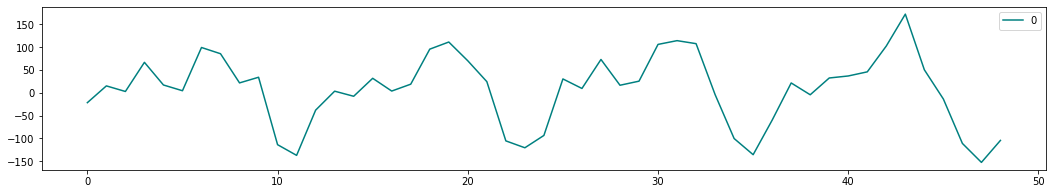

In [46]:
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
residuals.plot(color='teal');

In [48]:
residuals.describe()

,0
count,49.00
mean,6.55
std,77.53
min,-152.88
25%,-21.83
50%,16.97
75%,50.30
max,172.45


En este caso nuestro sesgo empeora significativamente (observe la media residual), así como nuestra métrica RMSE. Un mejoramiento o cambio de modelo es sugerido.

## Punto 8

In [49]:
# prepare problem
X = s.values
window = 1
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [50]:
print('RMSE: %.3f' % rmse)

RMSE: 33.710


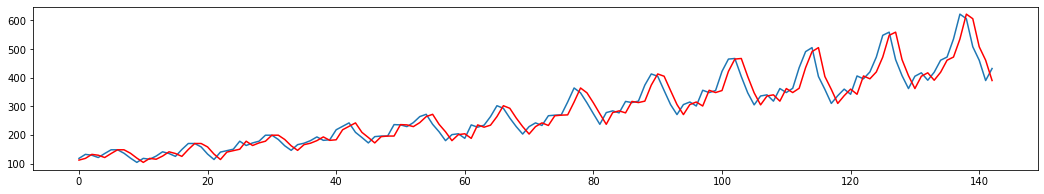

In [51]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

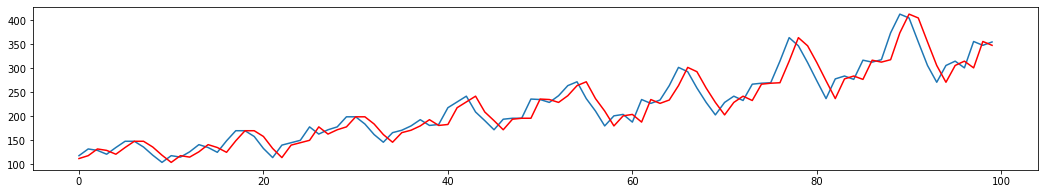

In [52]:
# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show()

Para una ventana de tamaño 5 y/o 4, nuestro RMSE continúa siendo malo, y es comparable con los modelos vistos anteriormente que no fueron satisfactorios. Sin embargo, al bajar este tamaño de ventana a 1, obtenemos un modelo que se ajusta mucho mejor a nuestros datos y que mejora significativamente el RMSE.